In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

import csv

from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Polygon
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np

import sklearn.datasets
import lightning.pytorch as pl
from sklearn.preprocessing import StandardScaler
from src.sampling.clustering import get_n_clustered
from src.vis.constants import CRITERIA_ORDER
from src.vis.helpers import format_criterium

In [2]:
COLD_PAWS_INPUT_DIR = 'sampling_methods_sklearn_distributions/input'
COLD_PAWS_OUTPUT_DIR = 'sampling_methods_sklearn_distributions/output'

In [3]:
N_POINTS = 200
N_SAMPLES = 10

In [4]:
pl.seed_everything(0)

# ============
# Generate sklearn.datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
noisy_circles = sklearn.datasets.make_circles(n_samples=N_POINTS, factor=0.5, noise=0.05)
noisy_moons = sklearn.datasets.make_moons(n_samples=N_POINTS, noise=0.05)
blobs = sklearn.datasets.make_blobs(n_samples=N_POINTS, random_state=8)
no_structure = np.random.rand(N_POINTS, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = sklearn.datasets.make_blobs(n_samples=N_POINTS, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = sklearn.datasets.make_blobs(
    n_samples=N_POINTS, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

Global seed set to 0


In [5]:
# generating features for cold paws (optional)
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # creating features for cold paws
    with open(os.path.join(COLD_PAWS_INPUT_DIR, f'{i_dataset}.csv'), 'w') as csv_file:
        csv_writer = csv.writer(csv_file)

        # header
        csv_writer.writerow(['name', 'label', 'feature'])

        for i in range(len(X)):
            feature = [str(x) for x in X[i]]
            feature_str = '[' + ', '.join(feature) + ']'

            csv_writer.writerow([
                str(i),
                f'tensor({i})',
                feature_str
            ])

Global seed set to 0


Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


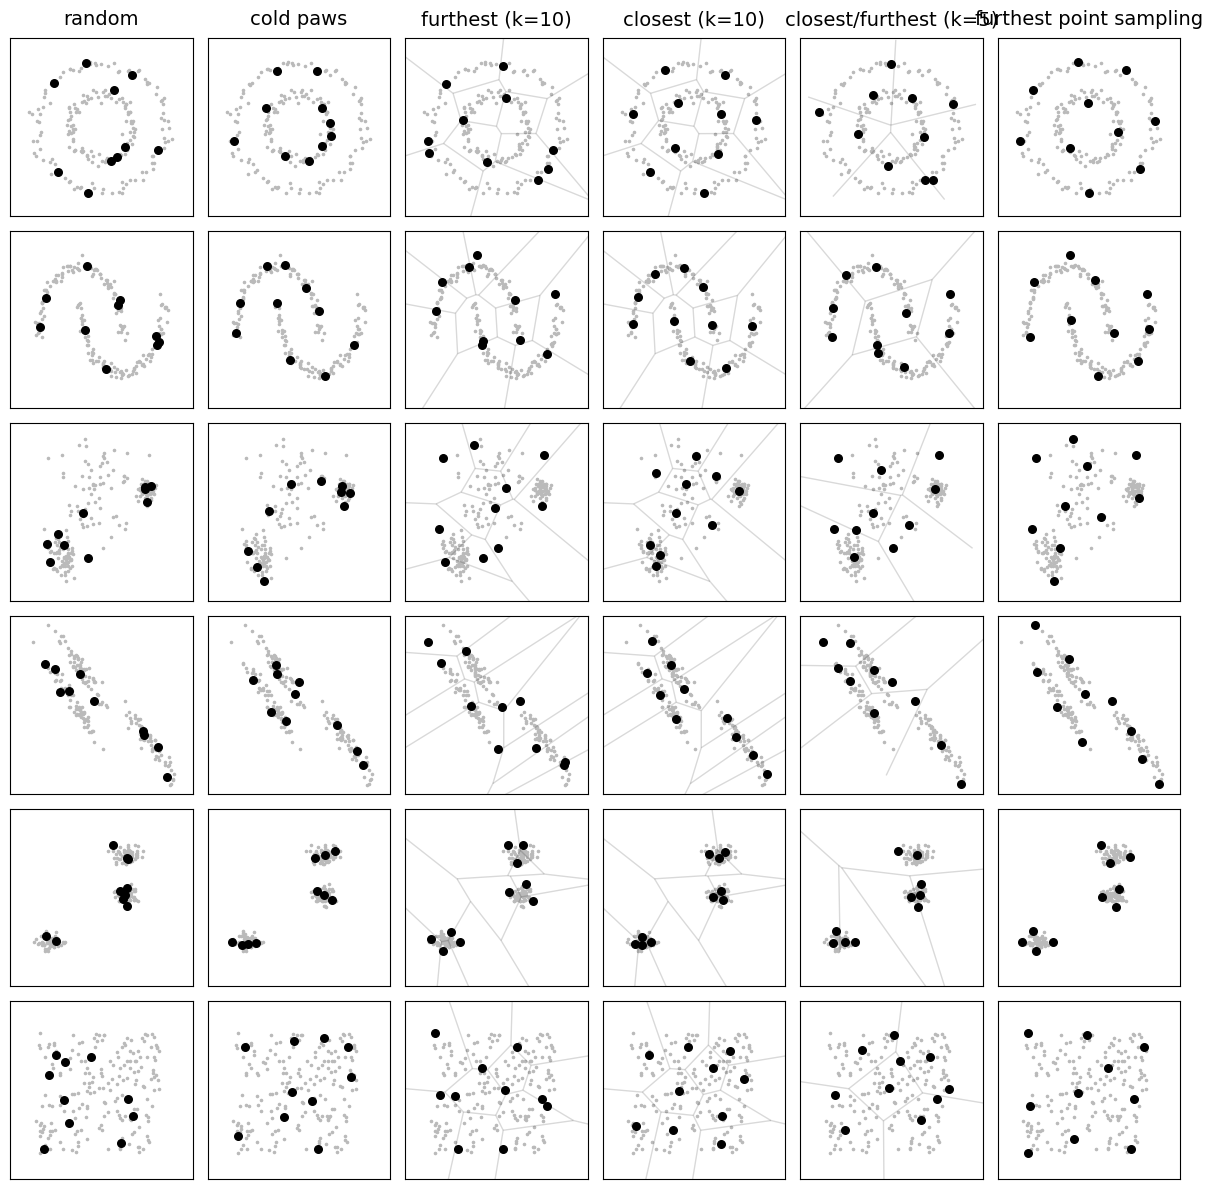

In [6]:
# ============
# Set up cluster parameters
# ============
coef = 2
plt.figure(figsize=(coef * len(CRITERIA_ORDER), coef * len(datasets)))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.05
)
ax_temp = None
plot_num = 1
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    for criterium in CRITERIA_ORDER:
        ax = plt.subplot(len(datasets), len(CRITERIA_ORDER), plot_num)

        n_clusters = None
        if criterium in ('closest',  'furthest'):
            n_clusters = N_SAMPLES
        elif criterium == 'half_in_half':
            n_clusters = N_SAMPLES // 2
        else:
            n_clusters = 1

        if criterium == 'cold_paws':
            indices = []
            with open(os.path.join(COLD_PAWS_OUTPUT_DIR, f'{i_dataset}.csv'), 'r') as csv_file:
                csv_reader = csv.DictReader(csv_file)
                for row in csv_reader:
                    indices.append(int(row['indices']))

            X_chosen = X[indices, :]
        else:
            pl.seed_everything(0)
            indices, cluster_indices, cluster_centers = get_n_clustered(
                features=X,
                n_samples=N_SAMPLES,
                n_clusters=n_clusters,
                mode='kmeans',
                criterium=criterium,
                verbose=True
            )
            X_chosen = X[indices, :]

            if n_clusters > 1:
                vor = Voronoi(cluster_centers)
                voronoi_plot_2d(
                    vor, ax=ax, 
                    show_points=False, show_vertices=False, 
                    # line_width=1, line_alpha=0.27,
                    line_width=1, line_alpha=0.15,
                )
                for child in ax.get_children():
                    if not isinstance(child, LineCollection):
                        continue

                    child.set_linestyle('solid')

        if i_dataset == 0:
            plt.title(format_criterium(criterium, N_SAMPLES), size=14, pad=10)

        plt.scatter(
            X[:, 0], X[:, 1], 
            color='#bababa', marker='.', s=10,
        )
        plt.scatter(
            X_chosen[:, 0], X_chosen[:, 1], 
            color='black', marker='o', s=30,
        )

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())

        plot_num += 1

plt.tight_layout()
plt.savefig('../outputs/sampling_methods_vertical.pdf')
plt.show()

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


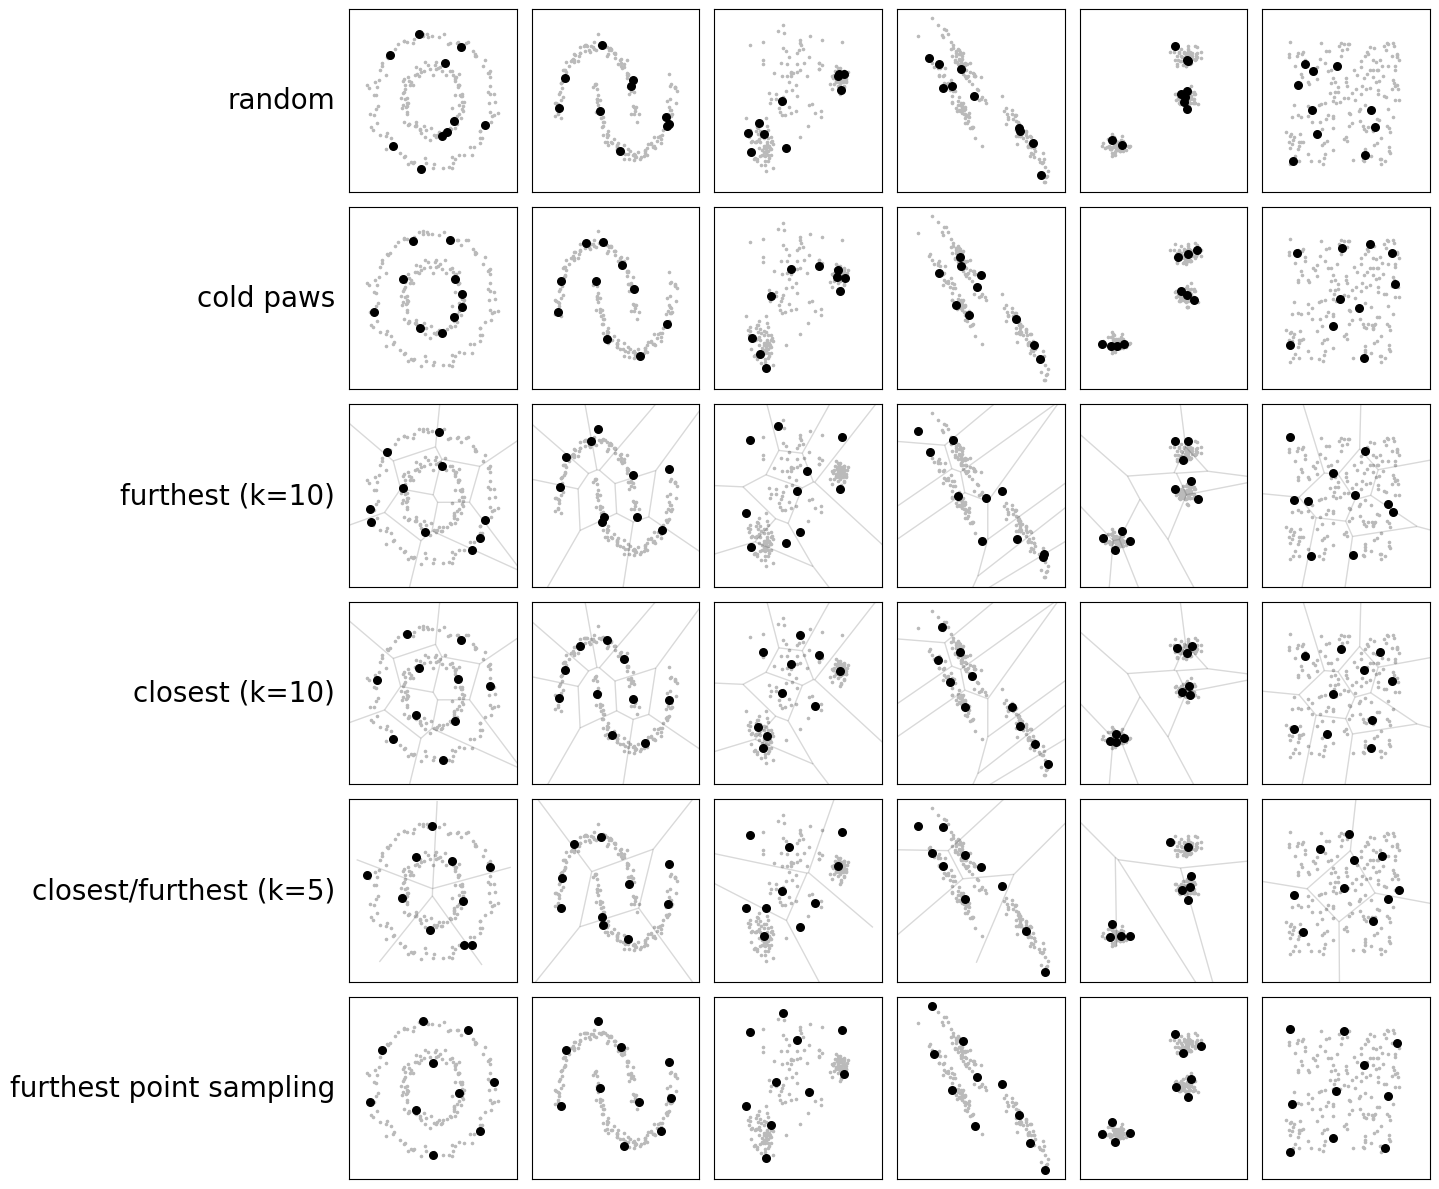

In [7]:
# ============
# Set up cluster parameters
# ============
coef = 2
plt.figure(figsize=(coef * (len(datasets) + 1.25), coef * len(CRITERIA_ORDER)))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.05
)
ax_temp = None
plot_num = 1
for criterium in CRITERIA_ORDER:
    for i_dataset, (dataset, algo_params) in enumerate(datasets):
        X, y = dataset

        # normalize dataset for easier parameter selection
        X = StandardScaler().fit_transform(X)

        ax = plt.subplot(len(datasets), len(CRITERIA_ORDER), plot_num)

        n_clusters = None
        if criterium in ('closest',  'furthest'):
            n_clusters = N_SAMPLES
        elif criterium == 'half_in_half':
            n_clusters = N_SAMPLES // 2
        else:
            n_clusters = 1

        if criterium == 'cold_paws':
            indices = []
            with open(os.path.join(COLD_PAWS_OUTPUT_DIR, f'{i_dataset}.csv'), 'r') as csv_file:
                csv_reader = csv.DictReader(csv_file)
                for row in csv_reader:
                    indices.append(int(row['indices']))

            X_chosen = X[indices, :]
        else:
            pl.seed_everything(0)
            indices, cluster_indices, cluster_centers = get_n_clustered(
                features=X,
                n_samples=N_SAMPLES,
                n_clusters=n_clusters,
                mode='kmeans',
                criterium=criterium,
                verbose=True
            )
            X_chosen = X[indices, :]

            if n_clusters > 1:
                vor = Voronoi(cluster_centers)
                voronoi_plot_2d(
                    vor, ax=ax, 
                    show_points=False, show_vertices=False, 
                    # line_width=1, line_alpha=0.27,
                    line_width=1, line_alpha=0.15,
                )
                for child in ax.get_children():
                    if not isinstance(child, LineCollection):
                        continue

                    child.set_linestyle('solid')

        if i_dataset == 0:
            plt.ylabel(
                format_criterium(criterium, N_SAMPLES), 
                size=20,  
                rotation=0,
                horizontalalignment='right',
                verticalalignment='center',
                # labelpad=6.0,
                labelpad=10,
            )

        plt.scatter(
            X[:, 0], X[:, 1], 
            color='#bababa', marker='.', s=10,
        )
        plt.scatter(
            X_chosen[:, 0], X_chosen[:, 1], 
            color='black', marker='o', s=30,
        )

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())

        plot_num += 1

plt.tight_layout()
plt.savefig('../outputs/sampling_methods_horizontal.pdf')
plt.savefig('../outputs/sampling_methods_horizontal.png', dpi=300)
plt.show()